In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, RNN, LSTM, GRU, SpatialDropout1D


In [2]:
import matplotlib.pyplot as plt

Ucitani su podaci preko excell tabele koja je skinuta sa "https://www.kaggle.com/datasets/milobele/sentiment140-dataset-1600000-tweets" web stranice.

In [3]:
data = pd.read_csv('sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=['Sentiment', 'Tweet ID', 'Date', 'Query', 'Username', 'Tweet'])

In [4]:
data.head(2)

,Sentiment,Tweet ID,Date,Query,Username,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


Sa obzirom na to da su tweetovi vec raspodeljeni na negativne i pozitivne (0 i 4 respektivno), remapirane su vrednosti u 0 i 1

In [5]:
def Sentiment_remap(x):
    if x == 0:
        return 0
    else:
        return 1

In [6]:
data['Sentiment'] = data['Sentiment'].apply(Sentiment_remap)

Takodje su uklonjeni korisnicki nalozi 

In [7]:
def username_removal(string):
    
    for i in range(string.count('@')): 
        username_begin_index = string.find('@')
        username_end_index = string[username_begin_index::].find(' ') + username_begin_index
    
        string = string.replace(string[username_begin_index:username_end_index+1],' ')
    
    return string                    

In [8]:
data['Tweet'] = data['Tweet'].apply(username_removal)

In [9]:
x = data['Tweet']
y = data['Sentiment']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.67, stratify=y, random_state=7)

Napravljen je tokenizator koji tokenizuja do 10 hiljada reci koji se pojavljuju u tekstu

In [11]:
tokenizer = Tokenizer(num_words=10000)

In [12]:
tokenizer.fit_on_texts(x_train)

In [13]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [14]:
x_train_seq[0]

[149, 350, 9, 4, 478, 9983, 3, 2174, 5346]

Srednja duzina tweeta je dobijena na sledeci nacin

In [15]:
non_zero = 0
duzina = len(x_train_seq)

for i in range(len(x_train_seq)):
    non_zero += np.count_nonzero(x_train_seq[i])
max_len = int(non_zero/duzina)
max_len

12

Tweetovi se paduju na prosecnu duzinu tweeta na sledeci nacin. U prvobitnim pokusajevima recenice su se padovale do 100 reci, sto je za posledicu imalo da model nije nista naucio, sto ce biti kasnije prikazano.

In [16]:
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

# MODEL 1 - Rekuretna neuronska mreza



In [17]:
# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

Napravljena je jednostavna rekurentna mreza sa sledecim parametrima.

In [18]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    #SpatialDropout1D(0.25),
    SimpleRNN(units=128),
    #LSTM(64),
    Dense(1, activation='sigmoid')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 128)           1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1313025 (5.01 MB)
Trainable params: 1313025 (5.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [22]:
callback = EarlyStopping(monitor='loss',patience=3)

In [23]:
history = model.fit(x_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[callback])

Epoch 1/10


13400/13400 [==============================] - 226s 17ms/step - loss: 0.4742 - accuracy: 0.7755 - val_loss: 0.4499 - val_accuracy: 0.7895
Epoch 2/10
13400/13400 [==============================] - 276s 21ms/step - loss: 0.4411 - accuracy: 0.7948 - val_loss: 0.4443 - val_accuracy: 0.7923
Epoch 3/10
13400/13400 [==============================] - 260s 19ms/step - loss: 0.4278 - accuracy: 0.8024 - val_loss: 0.4385 - val_accuracy: 0.7970
Epoch 4/10
13400/13400 [==============================] - 243s 18ms/step - loss: 0.4191 - accuracy: 0.8072 - val_loss: 0.4375 - val_accuracy: 0.7968
Epoch 5/10
13400/13400 [==============================] - 258s 19ms/step - loss: 0.4119 - accuracy: 0.8115 - val_loss: 0.4389 - val_accuracy: 0.7963
Epoch 6/10
13400/13400 [==============================] - 308s 23ms/step - loss: 0.4075 - accuracy: 0.8141 - val_loss: 0.4432 - val_accuracy: 0.7967
Epoch 7/10
13400/13400 [==============================] - 312s 23ms/step - loss: 0.4041 - accuracy: 0.81

In [24]:
loss, accuracy = model.evaluate(x_test_pad, y_test)

16500/16500 [==============================] - 54s 3ms/step - loss: 0.4449 - accuracy: 0.7930


In [25]:
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.4449, Test Accuracy: 0.7930


In [26]:
def plot_graphs(history):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(history.epoch, history.history['loss'], label='training')
    plt.plot(history.epoch, history.history['val_loss'], label='validation')
    plt.legend(loc='best')
    plt.xlabel('Epochs')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(history.epoch, history.history['accuracy'], label='training')
    plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
    plt.legend(loc='best')
    plt.xlabel('Epochs')

    plt.show()

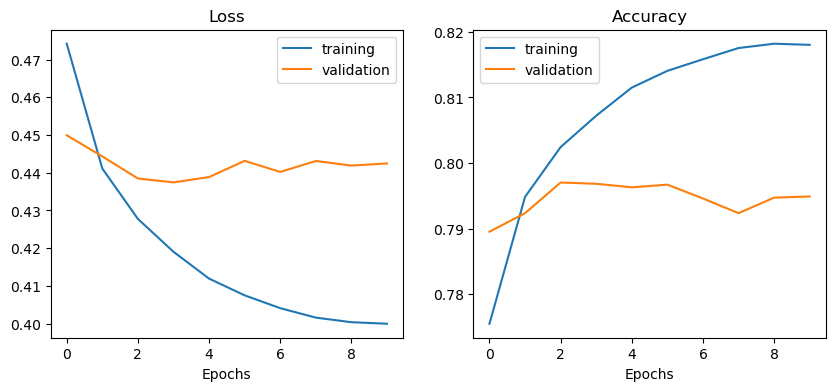

In [27]:
plot_graphs(history)

# Modeli sa drugim paddingom

In [28]:
max_len = 100
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [29]:
model1 = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    #SpatialDropout1D(0.25),
    SimpleRNN(units=128),
    #LSTM(64),
    Dense(1, activation='sigmoid')
])

In [30]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
history1 = model1.fit(x_train_pad, y_train, epochs=3, batch_size=64, validation_split=0.2, callbacks=[callback])

Epoch 1/3
13400/13400 [==============================] - 579s 43ms/step - loss: 0.6942 - accuracy: 0.5082 - val_loss: 0.6931 - val_accuracy: 0.5003
Epoch 2/3
13400/13400 [==============================] - 578s 43ms/step - loss: 0.6945 - accuracy: 0.5051 - val_loss: 0.6966 - val_accuracy: 0.5123
Epoch 3/3
13400/13400 [==============================] - 580s 43ms/step - loss: 0.6945 - accuracy: 0.5058 - val_loss: 0.6929 - val_accuracy: 0.5179


In [33]:
loss, accuracy = model1.evaluate(x_test_pad, y_test)

16500/16500 [==============================] - 114s 7ms/step - loss: 0.6931 - accuracy: 0.5161


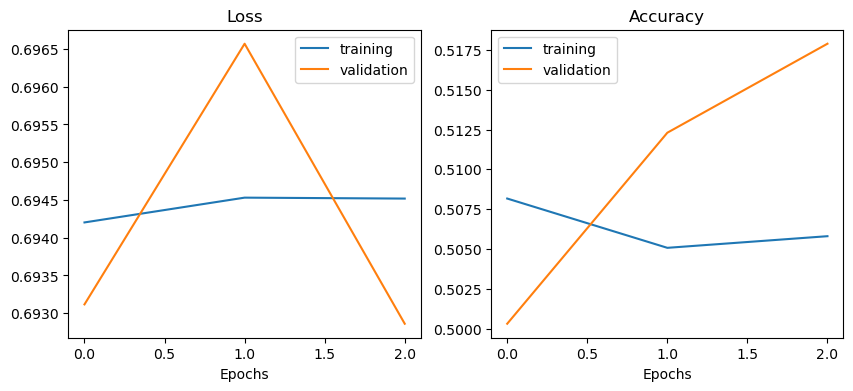

In [34]:
plot_graphs(history1)

Kao sto se moze primetiti, posledica velikog broja 0 u samim recenicama ima za posledicu da se gubi sam sentiment tweeta ako je on vecinski sacinjen od velikog broja 0. Na osnovu takvih podataka, model ima 50% tacnost, tj. nema korisnih informacija od kojih moze da nauci sentiment.